'1.8.0a0+52ea372'

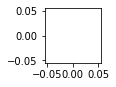

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
# force plt on windows 10
import matplotlib.pyplot as plt
plt.figure(figsize=(1,1))
plt.plot()

import sys
sys.path.append("..")

import torch
import torch.nn as nn
import numpy as np
import aggets.ds.window as window
import aggets.ds.hyper_f_load as hfl
import aggets.ds.window as window
import aggets.train as train

## DISABLE THIS
import warnings
warnings.filterwarnings("ignore")
torch.__version__

In [27]:
%%time
import aggets.ds.hyper_f_load as hyper_f_load
data = hyper_f_load.load()

CPU times: user 852 ms, sys: 48 ms, total: 900 ms
Wall time: 899 ms


In [28]:
%%time
import aggets.ds.aggregate_nd as agg_nd
cols = ['att1', 'att2', 'att3', 'att4', 'att5', 'att6', 'att7', 'att8', 'att9', 'att10']
train_np = agg_nd.as_np(data['train'], cols, 'class')
val_np = agg_nd.as_np(data['val'], cols, 'class')
test_np = agg_nd.as_np(data['test'], cols, 'class')

window = agg_nd.window_generator(train_np, val_np, test_np, window_size=500, e=0.00001, hist_bins=20, hist_dim=1)

ranges -> [[-9.9999997e-06  1.0000089e+00]
 [-6.9999996e-06  1.0000089e+00]
 [-9.9999997e-06  1.0000100e+00]
 [-8.9999994e-06  1.0000100e+00]
 [-8.9999994e-06  1.0000100e+00]
 [-9.9999997e-06  1.0000080e+00]
 [-8.9999994e-06  1.0000100e+00]
 [-9.9999997e-06  1.0000089e+00]
 [-6.9999996e-06  1.0000070e+00]
 [-5.9999998e-06  1.0000089e+00]
 [-9.9999997e-06  1.0000100e+00]]
CPU times: user 36 ms, sys: 8 ms, total: 44 ms
Wall time: 42.1 ms


In [29]:
%%time
window.init_structures()

CPU times: user 1min 16s, sys: 13.5 s, total: 1min 29s               
Wall time: 1min 16s


In [30]:
%%time
import aggets.util as util
# util.save(window, path='nwindow_02.bin')
# w = util.load(path='nwindow_01.bin') # 5 bins, 2 dim, 500ws
w = util.load(path='nwindow_02.bin') # 20 bins, 1 dim, 500ws

CPU times: user 136 ms, sys: 64 ms, total: 200 ms
Wall time: 199 ms


In [31]:
%%time
print('aggregates')
print(w.train_agges.shape)
print(w.val_agges.shape)
print(w.test_agges.shape)
print('models')
print(w.train_models.shape)
print(w.val_models.shape)
print(w.test_models.shape)
print('')
from aggets.model.aggregate import WindowConfig
dl = w.wrapped(WindowConfig(output_sequence_length=5, input_sequence_length=10),
              other={'source': 'agg', 'target': 'lr'}).train

print('sets')
def get_item_shape(item):
    if type(item) == list:
       return (item[0].shape, item[1].shape)
    return item.shape
[get_item_shape(l) for l in next(iter(dl))]


aggregates
torch.Size([1400, 5, 2, 10, 20])
torch.Size([400, 5, 2, 10, 20])
torch.Size([200, 5, 2, 10, 20])
models
torch.Size([1400, 5, 11])
torch.Size([400, 5, 11])
torch.Size([200, 5, 11])

sets
CPU times: user 12 ms, sys: 8 ms, total: 20 ms
Wall time: 42.6 ms


[torch.Size([32, 10, 2, 10, 20]), torch.Size([32, 5, 11])]

training model autoreg-lstm
saving model MTL=0.10524486085992255, MVL=0.15796288652498214
saving model MTL=0.058384119502959714, MVL=0.09709486963807559
saving model MTL=0.03030374034174851, MVL=0.09480860975922131
saving model MTL=0.02530009127844314, MVL=0.0903378331758937


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

CPU times: user 8min 50s, sys: 2.08 s, total: 8min 52s
Wall time: 1min 44s


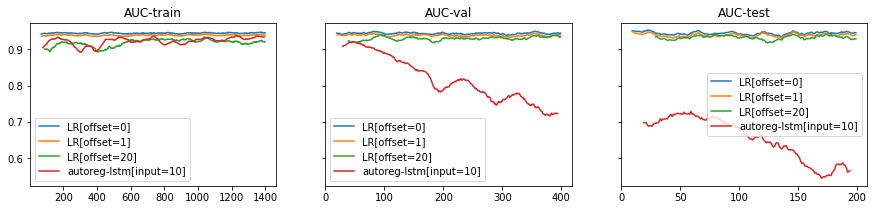

In [37]:
%%time
import aggets.model.aggregate2 as agg_m
import aggets.model.simple as simple
# HIST -> LR
hidden = 256

flatten = agg_m.Flatten(out_seq=5)
inp = nn.Sequential(
    flatten,
    simple.mlp(features=400, num_layers=1, out_features=hidden) # DMAJ: needed to chenge it to 400
)
out = simple.mlp(features=hidden, num_layers=1, out_features=11)

lstm = agg_m.AutoregLstm(input=inp, output=out, in_len=10, out_len=5, hidden=hidden)
# -------
lstm.name = 'autoreg-lstm'
train.train_window_models([lstm], w, patience=5, validate=True, weight_decay=0, max_epochs=1000,
                          lrs=[0.0001, 0.00001],
                          source='agg', target='lr', log=False)
# -------
_, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
w.plot_lr(axs=axs)
w.plot_model(lstm, axs=axs, other={'source':'agg', 'target':'lr'})

training model autoreg-lstm
saving model MTL=0.1179724487428841, MVL=0.24672178508805448
saving model MTL=0.07630983130654431, MVL=0.1613585406639537
saving model MTL=0.04972353496927819, MVL=0.09085118111039771
saving model MTL=0.034973017382113614, MVL=0.08704407903991762


<Figure size 432x288 with 0 Axes>

saving model MTL=0.03154145988897519, MVL=0.08659520421604641
saving model MTL=0.030207898768205798, MVL=0.08655422193105103
saving model MTL=0.02777127617721184, MVL=0.08634495344318327
saving model MTL=0.025575861206046446, MVL=0.08620838833148362


<Figure size 432x288 with 0 Axes>

CPU times: user 19min 29s, sys: 5.25 s, total: 19min 34s
Wall time: 3min 33s


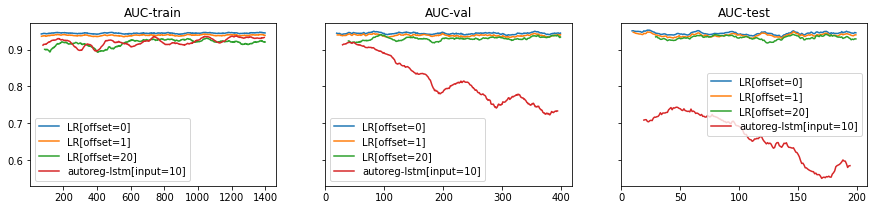

In [39]:
%%time
import aggets.model.aggregate2 as agg_m
import aggets.model.simple as simple
# HIST+LR -> LR
hidden = 256

inp = nn.Sequential(
    agg_m.FlatCat(),
    simple.mlp(features=411, num_layers=1, out_features=hidden) # DMAJ: needed to chenge it to 411
)
out = simple.mlp(features=hidden, num_layers=2, out_features=11)

lstm = agg_m.AutoregLstm(input=inp, output=out, in_len=10, out_len=5, hidden=hidden)
# -------
lstm.name = 'autoreg-lstm'
train.train_window_models([lstm], w, patience=10, validate=True, weight_decay=0, max_epochs=1000,
                          lrs=[0.0001, 0.00001],
                          source='all', target='lr', log=False)
# -------
_, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
w.plot_lr(axs=axs)
w.plot_model(lstm, axs=axs, other={'source':'all', 'target':'lr'})

training model autoreg-lstm
saving model MTL=0.06257687321086543, MVL=0.04041991523299061
saving model MTL=0.027332020684256466, MVL=0.03362008886503392
saving model MTL=0.025668814615987308, MVL=0.03017104276623882
saving model MTL=0.025193332976430928, MVL=0.030042954461007822
saving model MTL=0.024206092470077746, MVL=0.02932623847097647
saving model MTL=0.023531530821405418, MVL=0.02917827213885354
saving model MTL=0.02340742917475077, MVL=0.028446628483103923
saving model MTL=0.023261771281036216, MVL=0.028426444554915192
saving model MTL=0.02309156952579634, MVL=0.027811320712331864
saving model MTL=0.022966840945252583, MVL=0.027361741014679926
saving model MTL=0.022841177137414796, MVL=0.02732365920406873
saving model MTL=0.022794855374056813, MVL=0.027224782976459284
saving model MTL=0.02272088645419123, MVL=0.02704590974284
saving model MTL=0.02269640086440865, MVL=0.026794487579924163
saving model MTL=0.02263185102492571, MVL=0.026773179743866452
saving model MTL=0.022592430

<Figure size 432x288 with 0 Axes>

CPU times: user 25min 44s, sys: 7.94 s, total: 25min 52s
Wall time: 4min 24s


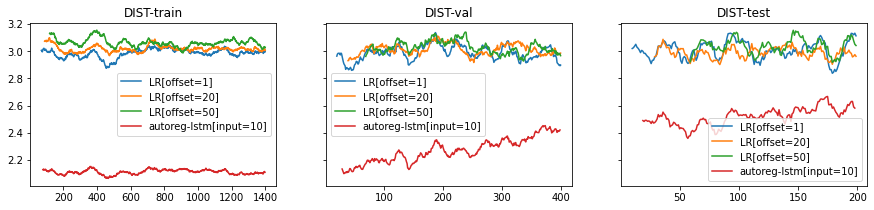

In [40]:
%%time
import aggets.model.aggregate2 as agg_m
import aggets.model.simple as simple
# HIST[0] -> HIST[0]
size = 200 #2250 // 2
hidden = 256
_out = 1

flatten = agg_m.Flatten(out_seq=_out)
inp = nn.Sequential(
    flatten,
    simple.mlp(features=size, num_layers=1, out_features=hidden)
)
out = nn.Sequential(
    simple.mlp(features=hidden, num_layers=1, out_features=size),
    flatten.reverse()
)
lstm = agg_m.AutoregLstm(input=inp, output=out, in_len=10, out_len=_out, hidden=hidden)
# -------
lstm.name = 'autoreg-lstm'
train.train_window_models([lstm], w, patience=10, validate=True, weight_decay=0, max_epochs=1000,
                          lrs=[0.0001],
                          source='agg[0]', target='agg[0]', log=False)
# -------
_, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
w.plot_agg_dist(axs=axs, select=lambda a: a[:, 0, 0])
w.plot_model_agg_dist(model=lstm, axs=axs, other={'source': 'agg[0]', 'target': 'agg[0]'})

CPU times: user 1.67 s, sys: 100 ms, total: 1.77 s
Wall time: 654 ms


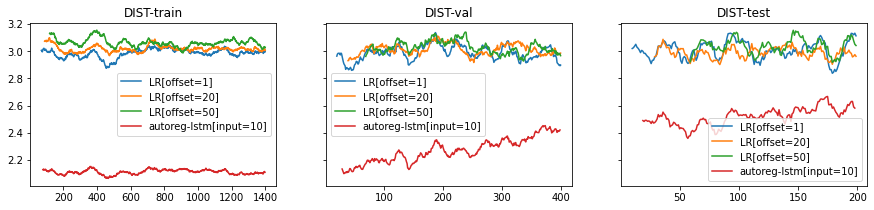

In [41]:
%%time
_, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
w.plot_agg_dist(axs=axs, select=lambda a: a[:, 0, 0])
w.plot_model_agg_dist(model=lstm, axs=axs, other={'source': 'agg[0]', 'target': 'agg[0]'})

training model autoreg-lstm
saving model MTL=0.1545411524354318, MVL=0.06288758769142823
saving model MTL=0.05676641605726076, MVL=0.06265708962913419
saving model MTL=0.05677243164919932, MVL=0.06253356095708784
saving model MTL=0.05682025417480447, MVL=0.06206783450773505
saving model MTL=0.05662661026992382, MVL=0.06083650093098156
saving model MTL=0.05606909123582578, MVL=0.058073573852660224
saving model MTL=0.05568411560096872, MVL=0.05785388768207832
saving model MTL=0.05559479188891726, MVL=0.05784897970371559
saving model MTL=0.05557235133825639, MVL=0.057841528512415336
saving model MTL=0.05547416179415283, MVL=0.057796834311524374
saving model MTL=0.05522287664336896, MVL=0.05751825704193506
saving model MTL=0.054753215846802115, MVL=0.057464560646502696
saving model MTL=0.054619546620807514, MVL=0.05741746473263522
saving model MTL=0.054556055797622835, MVL=0.05732174614658121
saving model MTL=0.05451403869264716, MVL=0.057299455780474864
saving model MTL=0.0542662166264079

<Figure size 432x288 with 0 Axes>

CPU times: user 30min, sys: 9.81 s, total: 30min 10s
Wall time: 5min 8s


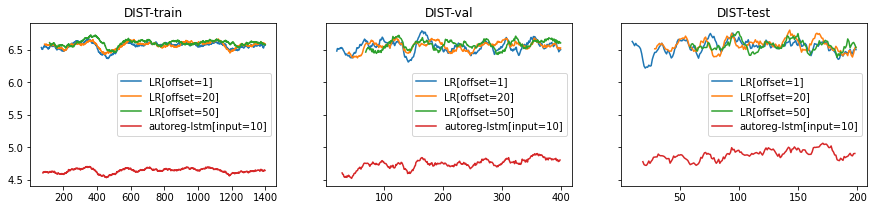

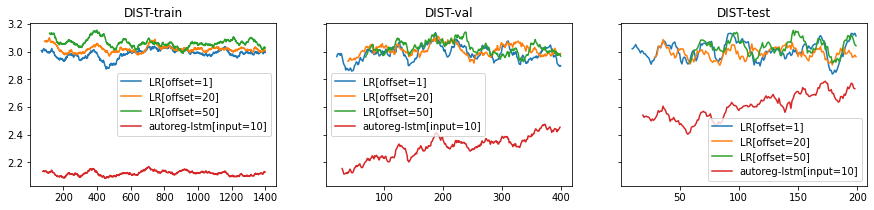

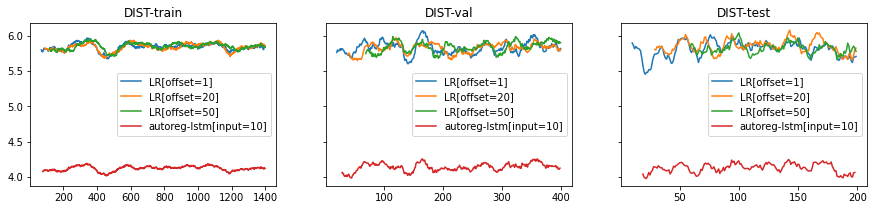

In [43]:
%%time
import aggets.model.aggregate2 as agg_m
import aggets.model.simple as simple
# HIST -> HIST
size = 400 # 2250 # DMAJ: needed to chenge it to 400
hidden = 256
_out = 1

flatten = agg_m.Flatten(out_seq=_out)
inp = nn.Sequential(
    flatten,
    simple.mlp(features=size, num_layers=1, out_features=hidden)
)
out = nn.Sequential(
    simple.mlp(features=hidden, num_layers=1, out_features=size),
    flatten.reverse()
)
lstm = agg_m.AutoregLstm(input=inp, output=out, in_len=10, out_len=_out, hidden=hidden)
# -------
lstm.name = 'autoreg-lstm'
train.train_window_models([lstm], w, patience=10, validate=True, weight_decay=0, max_epochs=1000,
                          lrs=[0.0001],
                          source='agg', target='agg', log=False)
# ------- p + d hist
_, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
w.plot_agg_dist(axs=axs, select=lambda a: a[:, 0])
w.plot_model_agg_dist(model=lstm, axs=axs, other={'source': 'agg', 'target': 'agg'})

# ------- p hist
_, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
w.plot_agg_dist(axs=axs, select=lambda a: a[:, 0, 0])
w.plot_model_agg_dist(model=lstm, axs=axs, other={'source': 'agg', 'target': 'agg'}, select=lambda x: x[:, 0, 0])

# ------- d hist
_, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
w.plot_agg_dist(axs=axs, select=lambda a: a[:, 0, 1])
w.plot_model_agg_dist(model=lstm, axs=axs, other={'source': 'agg', 'target': 'agg'}, select=lambda x: x[:, 0, 1])

training model autoreg-lstm
saving model MTL=0.09366264848321813, MVL=0.18284213323085036
saving model MTL=0.04740976845236143, MVL=0.09689234319280406
saving model MTL=0.02557500166827083, MVL=0.09206948869052481
saving model MTL=0.021633875715087087, MVL=0.08998495144922225
saving model MTL=0.020738881802366625, MVL=0.08886668415831737
saving model MTL=0.020209563973312555, MVL=0.08855348880418011
saving model MTL=0.01567594942632496, MVL=0.0869339572601631
saving model MTL=0.014970408675308052, MVL=0.08661387311141999
saving model MTL=0.013389225916138716, MVL=0.08577277035009666
saving model MTL=0.01272470191601784, MVL=0.08508788794279099
saving model MTL=0.012513908643430004, MVL=0.08320377950297027
saving model MTL=0.012292577515995723, MVL=0.08256671113557502
saving model MTL=0.01217964557235554, MVL=0.08024605009399477
saving model MTL=0.01198860006793166, MVL=0.07836769716661485
saving model MTL=0.011864906164049277, MVL=0.07798005933644342
saving model MTL=0.0117621439968317

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

CPU times: user 7min 57s, sys: 1.35 s, total: 7min 58s
Wall time: 2min 16s


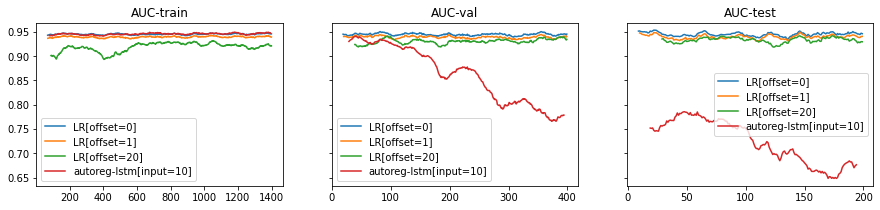

In [44]:
%%time
import aggets.model.aggregate2 as agg_m
import aggets.model.simple as simple
# LR -> LR
size = 11
hidden = 16
inp = simple.mlp(features=size, num_layers=1, out_features=hidden)
out = simple.mlp(features=hidden, num_layers=1, out_features=size)
lstm = agg_m.AutoregLstm(input=inp, output=out, in_len=10, out_len=5, hidden=16)
# -------
lstm.name = 'autoreg-lstm'
train.train_window_models([lstm], w, patience=20, validate=True, weight_decay=0, max_epochs=1000,
                          lrs=[0.001, 0.0001],
                          source='lr', target='lr', log=False)
# -------
_, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
w.plot_lr(axs=axs)
w.plot_model(lstm, axs=axs, other={'source':'lr', 'target':'lr'})

training model autoreg-lstm
saving model MTL=0.4518178209252314, MVL=0.36644983535907305
saving model MTL=0.14418454632299757, MVL=0.3354075101555371
saving model MTL=0.13923641441201945, MVL=0.3165239466995489
saving model MTL=0.13857954381666052, MVL=0.29812107369547985
saving model MTL=0.1210109886431366, MVL=0.16849211029341962
saving model MTL=0.09941902965170528, MVL=0.16347464430527608
saving model MTL=0.08962264595502013, MVL=0.1523761480558114
saving model MTL=0.08482413944027839, MVL=0.14830218841795062
saving model MTL=0.07807586372855606, MVL=0.14019630482939424


<Figure size 432x288 with 0 Axes>

CPU times: user 52min 39s, sys: 15.7 s, total: 52min 55s
Wall time: 9min 37s


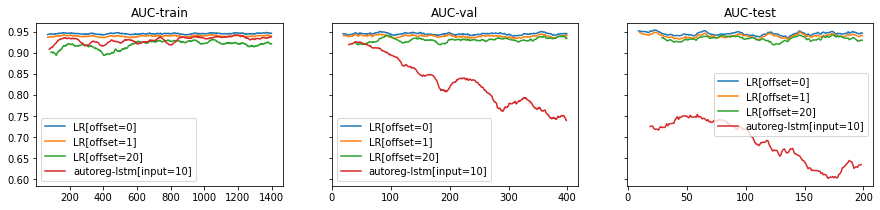

In [49]:
%%time
import aggets.model.aggregate2 as agg_m
import aggets.model.simple as simple
# HIST+LR -> HIST+LR
hidden = 512
flatcat = agg_m.FlatCat()

inp = nn.Sequential(
    flatcat,
    simple.mlp(features=411, num_layers=2, out_features=hidden) # DMAJ: needed to chenge it to 400
)
out = nn.Sequential(
    simple.mlp(features=hidden, num_layers=2, out_features=411), # DMAJ: needed to chenge it to 400
    flatcat.reverse()
)
lstm = agg_m.AutoregLstm(input=inp, output=out, in_len=10, out_len=1, hidden=hidden, num_layers=2)

loss = nn.MSELoss()

def criterion(x, y):
    return loss(x[0], y[0]) + loss(x[1], y[1])
# -------
lstm.name = 'autoreg-lstm'
train.train_window_models([lstm], w, patience=10, validate=True, weight_decay=0, max_epochs=1000,
                          lrs=[0.0001],
                          source='all', target='all', log=False,
                          criterion=criterion)
# -------
_, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
w.plot_lr(axs=axs)
w.plot_model(lstm, axs=axs, other={'source':'all', 'target':'all'}, select=lambda x: x[1])

In [52]:
%%time
# import aggets.model.aggregate2 as agg_m
# import aggets.model.simple as simple
# import aggets.model.fourier as fourier
# # HIST[0] -> HIST[0]
# size = 20

# frr = fourier.HistogramLerner(size=size, hists=10, types=1, t_in=10)
# frr = fourier.FAdapter2(frr)
# frr.window_config = WindowConfig(output_sequence_length=1, input_sequence_length=10, label_stride=1)
# # -------
# frr.name = 'fourier'
# train.train_window_models([frr], w, patience=2, validate=True, weight_decay=0, max_epochs=10,
#                           lrs=[0.001, 0.0001],
#                           source='agg[0]', target='agg[0]', log=False)

# # ------- p hist
# _, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
# w.plot_agg_dist(axs=axs, select=lambda a: a[:, 0, 0])
# w.plot_model_agg_dist(model=frr, axs=axs, other={'source': 'agg[0]', 'target': 'agg[0]'})

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 10.3 µs


In [57]:
# ------- p hist
# _, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
# w.plot_agg_dist(axs=axs, select=lambda a: a[:, 0, 0]) # sample 0, hist_type 0
# w.plot_model_agg_dist(model=frr, axs=axs, other={'source': 'agg[0]', 'target': 'agg[0]'})

In [62]:
%%time
# import aggets.model.aggregate2 as agg_m
# import aggets.model.simple as simple
# import aggets.model.fourier as fourier
# # HIST[0] -> HIST[0]
# size = 20

# frr = fourier.HistogramLerner(extra_dims=1, t_in=10)
# frr = fourier.FAdapter2(frr)
# frr.window_config = WindowConfig(output_sequence_length=1, input_sequence_length=10, label_stride=1)
# # -------
# frr.name = 'fourier'
# train.train_window_models([frr], w, patience=2, validate=True, weight_decay=0, max_epochs=10,
#                           lrs=[0.001, 0.0001],
#                           source='agg[0]', target='agg[0]', log=False)

# # ------- p hist
# _, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
# w.plot_agg_dist(axs=axs, select=lambda a: a[:, 0, 0])
# w.plot_model_agg_dist(model=frr, axs=axs, other={'source': 'agg[0]', 'target': 'agg[0]'})

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.54 µs


In [64]:
%%time
# import aggets.model.aggregate2 as agg_m
# import aggets.model.simple as simple
# import aggets.model.fourier as fourier
# # LR -> LR
# size = 11

# frr = fourier.HistogramLerner(extra_dims=0, t_in=10)
# frr = fourier.FAdapter2(frr)
# frr.window_config = WindowConfig(output_sequence_length=1, input_sequence_length=10, label_stride=1)
# # -------
# frr.name = 'fourier'
# train.train_window_models([frr], w, patience=2, validate=True, weight_decay=0, max_epochs=10,
#                           lrs=[0.001, 0.0001],
#                           source='lr', target='lr', log=False)

# # ------- lr
# _, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
# w.plot_lr(axs=axs)
# w.plot_model(frr, axs=axs, other={'source':'lr', 'target':'lr'})

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.78 µs


In [66]:
%%time
# import torch.nn as nn

# class MultiLearner(nn.Module):
#     def __init__(self):
#         super(MultiLearner, self).__init__()
#         self.lr_learner = fourier.HistogramLerner(extra_dims=0, t_in=10)
#         self.agg_learner = fourier.HistogramLerner(extra_dims=2, t_in=10)
#         self.fc = simple.mlp(400 + 11, num_layers=2, out_features=11)

#     def forward(self, x):
#         ts, lr = x
#         lr = self.lr_learner(lr)
#         ts = self.agg_learner(ts)
#         lr = lr.flatten(start_dim=1)
#         ts = ts.flatten(start_dim=1)
#         return self.fc(torch.cat([ts, lr], dim=-1)).reshape(ts.shape[0], 1, 11)

    
# import aggets.model.aggregate2 as agg_m
# import aggets.model.simple as simple
# import aggets.model.fourier as fourier
# # HIST+LR -> LR
# frr = MultiLearner()
# frr.window_config = WindowConfig(output_sequence_length=1, input_sequence_length=10, label_stride=1)
# # -------
# frr.name = 'fourier'
# train.train_window_models([frr], w, patience=2, validate=True, weight_decay=0, max_epochs=10,
#                           lrs=[0.001, 0.0001],
#                           source='all', target='lr', log=False)

# # ------- lr
# _, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
# w.plot_lr(axs=axs)
# w.plot_model(frr, axs=axs, other={'source':'all', 'target':'lr'})

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 10.3 µs


In [69]:
%%time
# class MultiLearner(nn.Module):
#     def __init__(self):
#         super(MultiLearner, self).__init__()
#         self.lr_learner = fourier.HistogramLerner(extra_dims=0, t_in=10)
#         self.agg_learner = fourier.HistogramLerner(extra_dims=2, t_in=10)
#         self.fc = simple.mlp(400 + 11, num_layers=2, out_features=11)

#     def forward(self, x):
#         ts, lr = x
#         lr = self.lr_learner(lr)
#         ts = self.agg_learner(ts)
#         lr = lr.flatten(start_dim=1)
#         ts = ts.flatten(start_dim=1)
#         return self.fc(torch.cat([ts, lr], dim=-1)).reshape(ts.shape[0], 1, 11)
# frr2 = MultiLearner()
# frr2.window_config = frr.window_config
# frr2.name = frr.name
# frr2.lr_learner = frr.lr_learner
# frr2.agg_learner = frr.agg_learner
# frr2.fc = frr.fc
# _, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
# w.plot_lr(axs=axs)
# w.plot_model(frr2, axs=axs, other={'source':'all', 'target':'lr'})

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.05 µs


training model DUMMY
saving model MTL=0.015260134806531832, MVL=0.01514854014958026
saving model MTL=0.015251966103603807, MVL=0.015141996203875933


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

CPU times: user 18.5 s, sys: 40 ms, total: 18.5 s
Wall time: 18.5 s


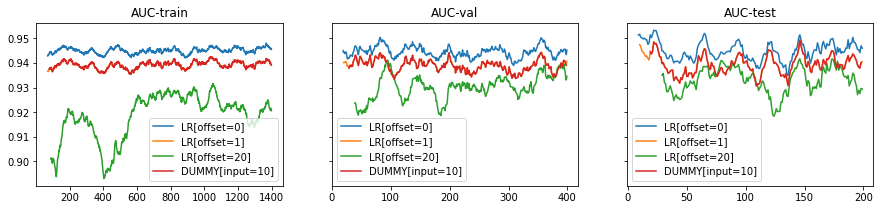

In [68]:
%%time
import aggets.model.aggregate as agg_m_old
import aggets.model.aggregate2 as agg_m
import aggets.model.simple as simple
import aggets.model.fourier as fourier
# HIST+LR -> LR
dmy = agg_m_old.DummyNet()
dmy.window_config = WindowConfig(output_sequence_length=1, input_sequence_length=10, label_stride=1)
# -------
dmy.name = 'DUMMY'
train.train_window_models([dmy], w, patience=2, validate=True, weight_decay=0, max_epochs=10,
                          lrs=[0.001, 0.0001],
                          source='all', target='lr', log=False)

# ------- lr
_, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
w.plot_lr(axs=axs)
w.plot_model(dmy, axs=axs, other={'source':'all', 'target':'lr'})